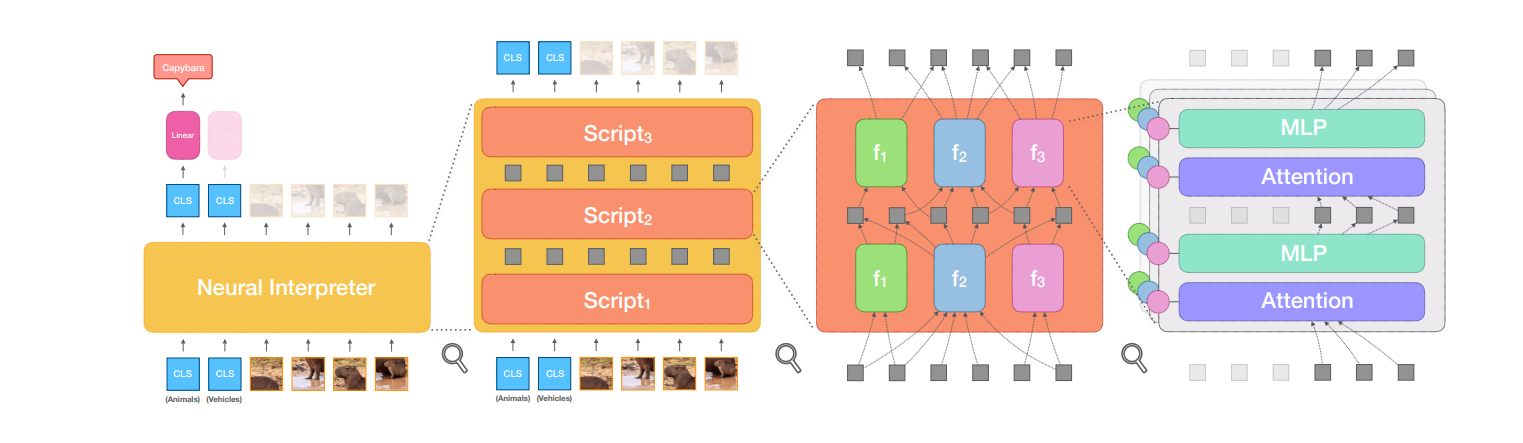

# Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
# Main Hyperparameters
img_size = 32                           # Dimension of spatial axes of input images
patch_size = 4                          # Patch size
in_channels = 3                         # Dimension of input channels
embed_dim = 256                         # Dimension of embeddings
batch_size = 128                        # Number of batch
epochs = 100                            # Number of epochs
dim_c = 192                             # Dimension of 'code' vector
dim_inter = 192                         # Dimension of intermediate feature vector
ns = 1                                  # Number of 'scripts'
ni = 8                                  # Number of 'function' iterations
nl = 1                                  # Number of LOCs
nf = 5                                  # Number of 'function's
n_cls = 3                               # Number of CLS tokens
n_heads = 4                             # Number of heads per LOC
loc_features = 128                      # Number of features per LOC head
type_inference_depth = 2                # Type Inference MLP depth
type_inference_width = 192              # Type Inference MLP width 
treshold = 1.4                          # Trunctation Parameter
signature_dim = 24                      # Dimension of type_space = dtype

# Pretraining Hyperparameters # Dimension of input channels
frozen_function_codes = False           # Required for pretraining
frozen_function_signatures = False      # Required for pretraining

# Optimization Hyperparameters          
beta1 = 0.9                             # Adam Optimizer beta1 parameter
beta2 = 0.999                           # Adam Optimizer beta2 parameter
lr = 1e-8                               # Learning Rate

# Dataloader 

In [3]:
def get_data_loader(datasetname, root, batch_size, transform):
  '''
  Digits dataset is a combination of three related datasets:
      1. SVHN 
      2. MNISTM   -> RESIZE all of them to [32 x 32]
      3. MNIST
  '''
  if datasetname == 'digits':
    # Get the dataset
    svhn = datasets.SVHN(root=root, 
                         split='train',
                         download=True,
                         transform=transform)
    # Get the loader
    loader = DataLoader(
        svhn,
        batch_size = batch_size,
        num_workers = 2,
        pin_memory = True,
        shuffle= True
    )

  return loader

In [4]:
# Parameters for dataset
datasetname = 'digits'
root = 'data/'
batch_size = 128
transform = transforms.Compose([
                  transforms.Resize((32, 32)),
                  transforms.ToTensor()])
loader = get_data_loader(datasetname, root, batch_size, transform)

Using downloaded and verified file: data/train_32x32.mat


In [5]:
data = next(iter(loader))

In [6]:
print('data[0]:', data[0].size())
print('data[1]:', data[1].size())

data[0]: torch.Size([128, 3, 32, 32])
data[1]: torch.Size([128])


In [7]:
def visualize_data(loader):
  # Get a sample of data
  samples = next(iter(loader))[0]
  
  # Determine grid size
  grid_width = 8 
  grid_height = 8
  
  # Create the grid
  image_grid = make_grid(samples[:grid_width*grid_height], nrow=grid_width)
  
  # Visualization arrangement
  plt.rcParams['figure.figsize'] = [grid_height, grid_width]
  plt.imshow(image_grid.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

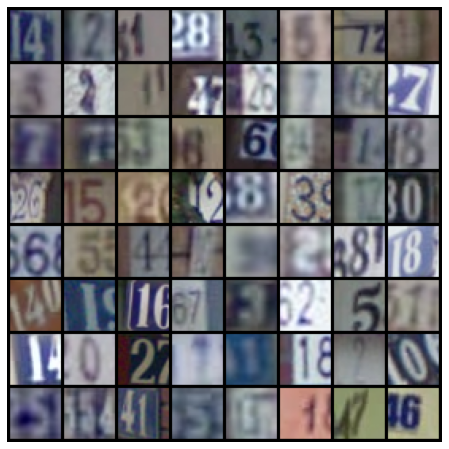

In [8]:
visualize_data(loader)

# Patch Embedding

In [9]:
from models.basic_layers import PatchEmbedding

In [10]:
# TEST
img = data[0]
print(img.shape)
patch_embedding = PatchEmbedding(img_size, 
                                 patch_size, 
                                 in_channels, 
                                 embed_dim)

embeddings = patch_embedding(img)
embeddings.size()

torch.Size([128, 3, 32, 32])


torch.Size([128, 64, 256])

In [11]:
patch_embedding.projection(img).flatten(2).transpose(1, 2).shape

torch.Size([128, 64, 256])

# MLP

In [12]:
from models.basic_layers import MLP

In [13]:
# TEST
mlp = MLP(embed_dim, type_inference_width, signature_dim)
type_vectors = mlp(embeddings)
type_vectors.size()

torch.Size([128, 64, 24])

# TypeInference

In [14]:
from models.basic_layers import TypeMatching

In [15]:
# TEST
s = torch.randn(nf, signature_dim) # (#num_funcs x #dtype)
type_matching = TypeMatching(embed_dim, type_inference_width, signature_dim, treshold)
# embeddings: (#tokens, #embed) =>typeinf => (#tokens, #dtype) => typematch => (#tokens, #funcs)
out = type_matching(embeddings, s) 
out.size()

torch.Size([128, 5, 64])

In [16]:
out

tensor([[[0.0000, 0.0000, 0.6016,  ..., 0.5991, 0.6029, 0.5966],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9999, 0.9999, 0.3984,  ..., 0.4009, 0.3971, 0.4034]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999]],

        [[0.6157, 0.6176, 0.0000,  ..., 0.6127, 0.6079, 0.6089],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3843, 0.3824, 0.9999,  ..., 0.3873, 0.3921, 0.3910]],

        ...,

     

In [17]:
a = torch.rand((2,5,4))
b = torch.rand(2,4)
torch.div(a,b.unsqueeze(1))
b.unsqueeze(1).shape

torch.Size([2, 1, 4])

In [18]:
out_norm = out.sum(dim=1).unsqueeze(1)+1e-5
torch.div(out, out_norm)

tensor([[[0.0000, 0.0000, 0.6016,  ..., 0.5991, 0.6029, 0.5966],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 0.3984,  ..., 0.4009, 0.3971, 0.4034]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.6157, 0.6176, 0.0000,  ..., 0.6127, 0.6079, 0.6090],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3843, 0.3824, 1.0000,  ..., 0.3873, 0.3921, 0.3910]],

        ...,

     

In [19]:
print(s.shape)
tmp = torch.where(s > -1, s, torch.tensor(0, dtype=torch.float))
print(tmp.shape)
print(tmp)

torch.Size([5, 24])
torch.Size([5, 24])
tensor([[ 9.5971e-01,  4.5322e-01, -9.4963e-02, -6.9218e-01, -9.6174e-01,
         -3.4599e-01,  1.0329e+00,  1.3367e+00, -8.9336e-01,  1.6526e+00,
         -5.4190e-01, -7.5600e-01, -4.9874e-01, -3.2210e-01,  0.0000e+00,
         -4.9555e-01,  8.2510e-02,  2.3852e-01,  0.0000e+00, -9.2950e-01,
         -3.8849e-02,  0.0000e+00,  3.8029e-02, -4.7573e-01],
        [-4.5469e-01,  4.1978e-01, -1.7805e-02, -3.2166e-01,  0.0000e+00,
          1.5412e+00,  1.8906e-01, -1.2277e-01,  0.0000e+00, -2.9469e-01,
          6.5667e-02, -4.5403e-03,  1.7849e-01,  1.5409e-01,  1.1497e+00,
         -4.0267e-01,  3.2078e-01,  0.0000e+00,  9.1974e-01, -8.4025e-01,
         -8.4872e-01,  0.0000e+00, -3.9945e-01, -6.4688e-01],
        [-7.3688e-01, -8.7592e-01,  0.0000e+00,  0.0000e+00,  1.0312e+00,
          7.6685e-01,  7.5908e-01,  1.0371e+00,  4.8236e-01, -7.3424e-01,
         -7.5883e-02,  2.9434e-01,  0.0000e+00,  4.3813e-01,  1.3042e+00,
          2.0760e-02, 

In [20]:
torch.zeros(1)

tensor([0.])

In [21]:
a = torch.rand(5, 4, 3) # [B x N x S]
b = torch.rand(6, 3)    # [F x S]
(a @ (b.transpose(0, 1))).size() # Expected: [B x N x F]

torch.Size([5, 4, 6])

In [22]:
from models.basic_layers import ModLin

In [23]:
dout = 74
dcond = 16
din = 256

x = torch.ones(128,64,din)
code = torch.rand(dcond)

modlin = ModLin(code, dout, din, dcond)

In [24]:
code = torch.ones(dim_c)
dout = 74
din = 256
dcond = dim_c

modlin = ModLin(code, dout, din, dcond)
modlin_out = modlin(embeddings)
modlin_out.size()

torch.Size([128, 64, 74])

In [25]:
from models.basic_layers import ModMLP

In [29]:
x = torch.ones(128,64,din)
code = torch.rand(dcond)

dout = 74
din = 256
dcond = dim_c
n_layers = 4

modmlp = ModMLP(n_layers, code, dout, din, dcond)

In [30]:
modmlp(x).shape

torch.Size([128, 64, 74])